# Citi Bike & Weather Analysis (2022) — Seaborn Visualizations

This notebook fulfills the exercise requirements using **Seaborn** for styling/plotting and **Matplotlib** for axis control (dual-axis seasonality chart). It reuses processed datasets and validates full 2022 temperature coverage.

In [21]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
sns.set_theme(style='whitegrid', palette='tab10')
plt.rcParams['figure.figsize'] = (12, 6)

In [23]:
cwd = Path.cwd()
if not (cwd/'Data').exists() and (cwd.parent/'Data').exists():
    os.chdir(cwd.parent)
print('Working directory:', Path.cwd())
print('Has Data folder:', (Path.cwd()/'Data').exists())

Working directory: C:\Users\User\Downloads\Citibike-Weather-Dashboard
Has Data folder: True


In [26]:
import pandas as pd
from pathlib import Path

# 1) Locate the merged CSV (you can add more candidates if needed)
merged_candidates = [
    Path(r"C:\Users\User\Downloads\Citibike-Weather-Dashboard\Data\Processed\citibike_weather_2022.csv"),
    Path(r"C:\Users\User\Downloads\Citibike-Weather-Dashboard\citibike_weather_2022.csv"),
    Path("Data/Processed/citibike_weather_2022.csv"),
    Path("citibike_weather_2022.csv"),
]

merged_path = next((p for p in merged_candidates if p.exists()), None)
if merged_path is None:
    raise FileNotFoundError(
        "Could not find citibike_weather_2022.csv. Looked for:\n" +
        "\n".join(str(p) for p in merged_candidates)
    )

merged_df = pd.read_csv(merged_path)

# 2) Create a date column from the trip start timestamp
# (adjust if your column is named differently)
merged_df["started_at"] = pd.to_datetime(merged_df["started_at"], errors="coerce")
merged_df["date"] = merged_df["started_at"].dt.date

# 3) Pick a temperature column that exists in your merged file
temp_candidates = ["temp_avg_c", "TAVG", "avg_temp", "temperature", "temp_c", "max_temp", "min_temp"]
temp_col = next((c for c in temp_candidates if c in merged_df.columns), None)
if temp_col is None:
    raise KeyError(f"No temperature column found. Available columns include:\n{merged_df.columns.tolist()}")

# 4) Build the daily table: trip counts + daily average temperature
daily = (
    merged_df
    .groupby("date", as_index=False)
    .agg(
        trips=("date", "size"),
        temp_avg_c=(temp_col, "mean")
    )
)

# downstream cells expect these names
trips_col = "trips"
temp_col = "temp_avg_c"

print("Loaded:", merged_path)
print(daily.head())

FileNotFoundError: Could not find citibike_weather_2022.csv. Looked for:
C:\Users\User\Downloads\Citibike-Weather-Dashboard\Data\Processed\citibike_weather_2022.csv
C:\Users\User\Downloads\Citibike-Weather-Dashboard\citibike_weather_2022.csv
Data\Processed\citibike_weather_2022.csv
citibike_weather_2022.csv

In [ ]:
min_date = daily['date'].min()
max_date = daily['date'].max()
missing_temp = daily[temp_col].isna().sum()
missing_trips = daily[trips_col].isna().sum()

print('Rows:', len(daily))
print('Date range:', min_date, 'to', max_date)
print('Missing temp_avg_c:', missing_temp)
print('Missing trips:', missing_trips)

assert pd.Timestamp('2022-01-01') <= min_date <= pd.Timestamp('2022-01-02')
assert pd.Timestamp('2022-12-30') <= max_date <= pd.Timestamp('2022-12-31')
assert missing_temp == 0, 'Temperature is missing—fix the weather merge first.'
assert missing_trips == 0, 'Trip counts are missing—fix daily trips aggregation first.'

## 2) Temperature time series

In [ ]:
sns.lineplot(data=daily, x='date', y=temp_col)
plt.title('Daily Average Temperature (2022)')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.tight_layout()
plt.show()

## 3) Dual-axis seasonality plot (Trips vs Temperature)

Seaborn draws both lines; Matplotlib's `twinx()` provides the secondary axis.

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=daily, x='date', y=trips_col, ax=ax1, color='tab:blue')
ax1.set_ylabel('Trips per day', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.lineplot(data=daily, x='date', y=temp_col, ax=ax2, color='tab:red')
ax2.set_ylabel('Average Temperature (°C)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.set_title('Seasonality: Trips vs Temperature (2022)')
fig.tight_layout()
plt.show()

## 4) Trip-level dataset (stations, box plot, FacetGrid)

This notebook loads a preprocessed trip-level parquet if present; otherwise it builds it once from raw CSVs and saves it for reuse.

In [5]:
import glob
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path(r"C:\Users\User\Downloads\Citibike-Weather-Dashboard")
RAW_TRIPS_DIR = PROJECT_ROOT / "Data" / "Raw" / "citibike-2022"
PROCESSED_DIR = PROJECT_ROOT / "Data" / "Processed"

processed_trip_path = PROCESSED_DIR / "trips_2022_clean.parquet"

if processed_trip_path.exists():
    trips = pd.read_parquet(processed_trip_path)
    print("Loaded:", processed_trip_path)
else:
    # Fall back to relative paths if running from repo root
    trip_files = sorted(glob.glob(str(RAW_TRIPS_DIR / "*.csv")))
    if len(trip_files) == 0:
        trip_files = sorted(glob.glob(r"Data\Raw\citibike-2022\*.csv"))

    if len(trip_files) == 0:
        raise FileNotFoundError("No raw trip CSVs found under Data/Raw/citibike-2022/*.csv")

    cols = pd.read_csv(trip_files[0], nrows=1).columns.tolist()

    start_time = "started_at" if "started_at" in cols else "starttime"
    end_time = "ended_at" if "ended_at" in cols else "stoptime"
    start_station = "start_station_name" if "start_station_name" in cols else ("start station name" if "start station name" in cols else None)
    rider_cat = "member_casual" if "member_casual" in cols else ("usertype" if "usertype" in cols else None)

    if start_station is None:
        raise KeyError(f"Could not find a start station column. Available columns: {cols}")

    usecols = [start_time, end_time, start_station]
    if rider_cat is not None:
        usecols.append(rider_cat)

    trips = pd.concat((pd.read_csv(f, usecols=usecols) for f in trip_files), ignore_index=True)

    trips[start_time] = pd.to_datetime(trips[start_time], errors="coerce")
    trips[end_time] = pd.to_datetime(trips[end_time], errors="coerce")

    trips["trip_minutes"] = (trips[end_time] - trips[start_time]).dt.total_seconds() / 60

    trips = trips.dropna(subset=[start_time, start_station, "trip_minutes"])
    trips = trips[(trips["trip_minutes"] > 0) & (trips["trip_minutes"] < 180)].copy()

    trips = trips.rename(columns={start_time: "started_at", end_time: "ended_at", start_station: "start_station_name"})
    if rider_cat is not None:
        trips = trips.rename(columns={rider_cat: "rider_type"})

    processed_trip_path.parent.mkdir(parents=True, exist_ok=True)
    trips.to_parquet(processed_trip_path, index=False)
    print("Built and saved:", processed_trip_path)

trips.head(), trips.columns.tolist(), trips.shape


Loaded: C:\Users\User\Downloads\Citibike-Weather-Dashboard\Data\Processed\trips_2022_clean.parquet


(           started_at            ended_at    start_station_name rider_type  \
 0 2022-01-26 18:50:39 2022-01-26 18:51:53  12 St & Sinatra Dr N     member   
 1 2022-01-28 13:14:07 2022-01-28 13:20:23      Essex Light Rail     member   
 2 2022-01-10 19:55:13 2022-01-10 20:00:37      Essex Light Rail     member   
 3 2022-01-26 07:54:57 2022-01-26 07:55:22  12 St & Sinatra Dr N     member   
 4 2022-01-13 18:44:46 2022-01-13 18:45:43  12 St & Sinatra Dr N     member   
 
    trip_minutes  
 0      1.233333  
 1      6.266667  
 2      5.400000  
 3      0.416667  
 4      0.950000  ,
 ['started_at',
  'ended_at',
  'start_station_name',
  'rider_type',
  'trip_minutes'],
 (889869, 5))

## 5) Bar chart: Top 20 starting stations

We use `tab20` to ensure enough distinct colors for 20 categories.

C:\Users\User\AppData\Local\Temp\ipykernel_23036\1274811195.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, y='start_station_name', x='trip_count', palette='tab20')


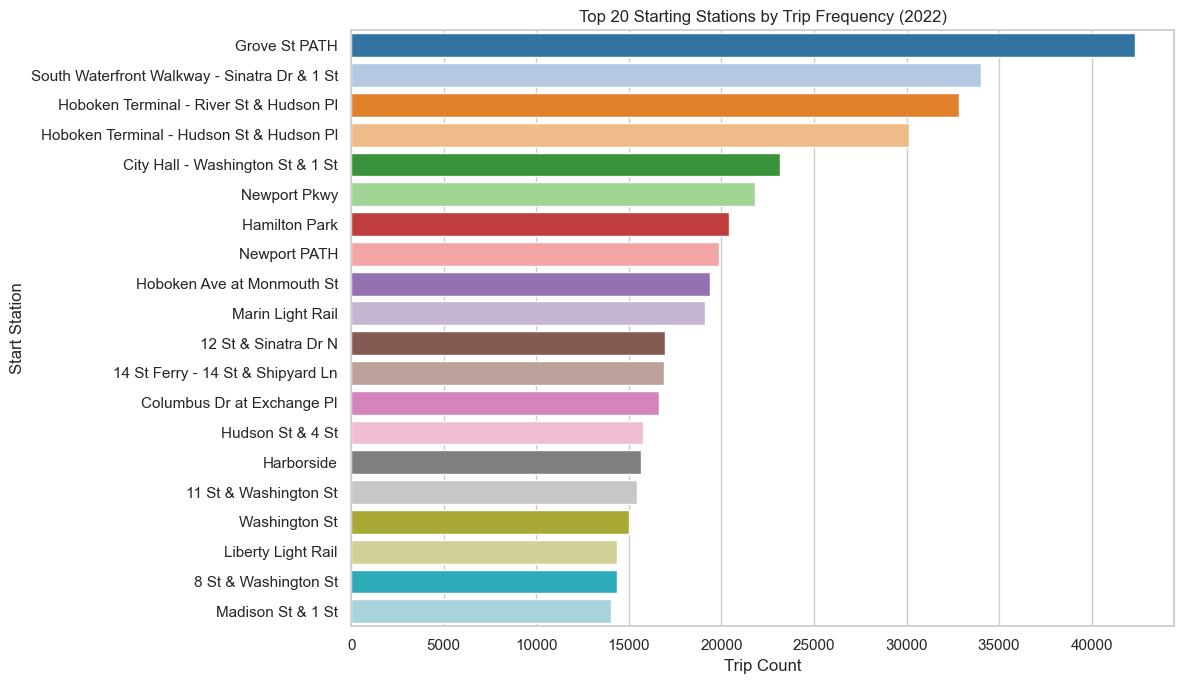

In [6]:
top20 = trips['start_station_name'].value_counts().head(20).reset_index()
top20.columns = ['start_station_name', 'trip_count']

plt.figure(figsize=(12, 7))
sns.barplot(data=top20, y='start_station_name', x='trip_count', palette='tab20')
plt.title('Top 20 Starting Stations by Trip Frequency (2022)')
plt.xlabel('Trip Count')
plt.ylabel('Start Station')
plt.tight_layout()
plt.show()

## 6) Box plot

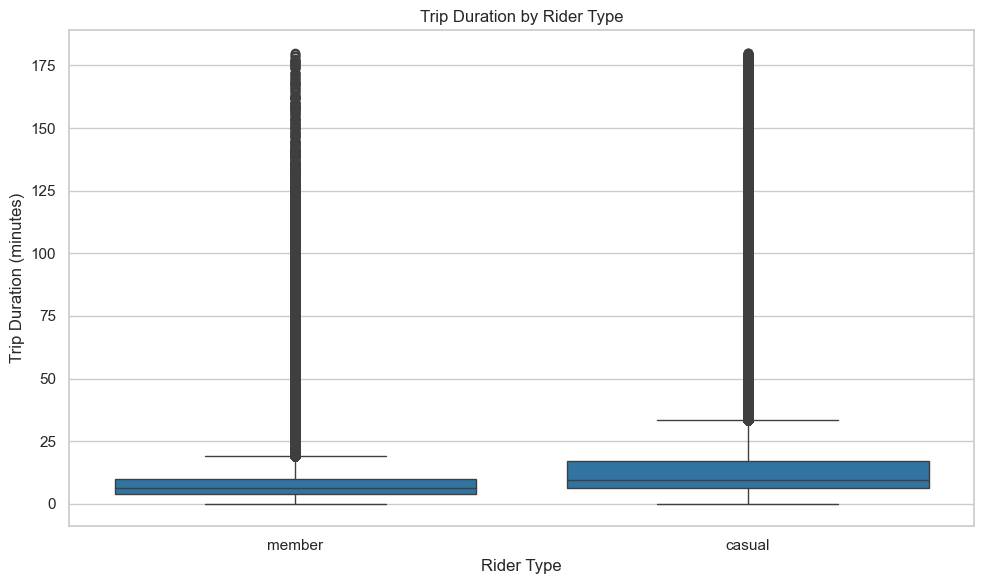

In [7]:
if 'rider_type' in trips.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=trips, x='rider_type', y='trip_minutes')
    plt.title('Trip Duration by Rider Type')
    plt.xlabel('Rider Type')
    plt.ylabel('Trip Duration (minutes)')
    plt.tight_layout()
    plt.show()
else:
    print('Skipped: rider_type column not available.')

### Box Plot Analysis

This box plot compares trip duration across rider categories. The median shows typical duration while the IQR reflects variability. Outliers represent occasional very long rides. **If the median duration of members is lower than casuals**, it suggests members may be using bikes for shorter routine trips (commuting/errands), while casuals may take longer rides for leisure or sightseeing.

## 7) FacetGrid

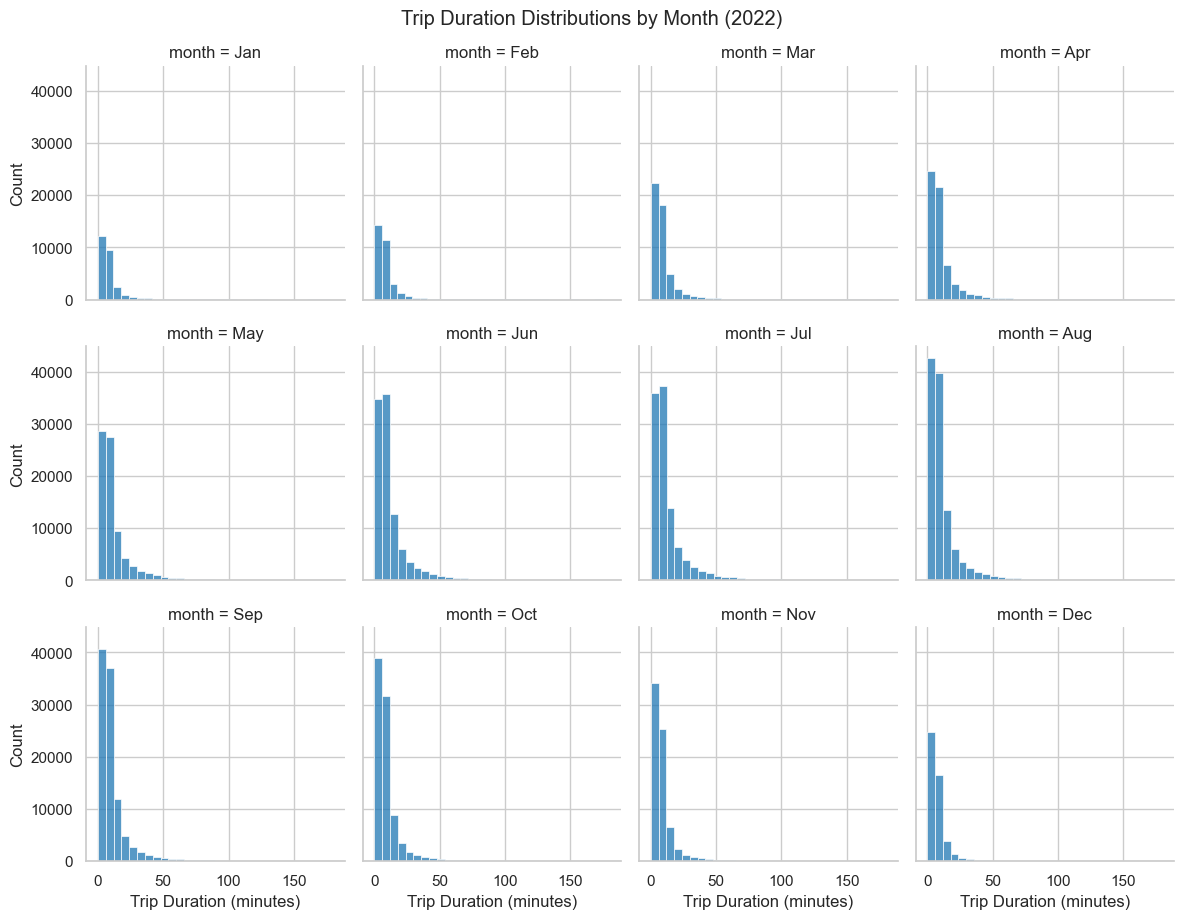

In [8]:
trips['month'] = trips['started_at'].dt.month_name().str[:3]
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

g = sns.FacetGrid(trips, col='month', col_order=month_order, col_wrap=4, height=3.0, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x='trip_minutes', bins=30)
g.set_axis_labels('Trip Duration (minutes)', 'Count')
g.fig.suptitle('Trip Duration Distributions by Month (2022)', y=1.02)
plt.show()

### FacetGrid Insight

The FacetGrid makes seasonality visible by showing each month’s duration distribution separately. Warmer months often show heavier right tails (more long rides), consistent with recreational usage. This helps interpret behavior changes that can be hidden when data is pooled across the full year.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
sns.lineplot(
    data=daily,
    x="date",
    y="daily_trips"
)

plt.title("Daily Citi Bike Trips – Full Year 2022 (Jan–Dec)")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.xlim(pd.Timestamp("2022-01-01"), pd.Timestamp("2022-12-31"))
plt.tight_layout()
plt.show()

NameError: name 'daily' is not defined

<Figure size 1200x400 with 0 Axes>

In [ ]:
nov_dec = daily[daily["date"].dt.month.isin([11, 12])]

plt.figure(figsize=(10, 4))
sns.lineplot(data=nov_dec, x="date", y="daily_trips")
plt.title("Citi Bike Trips – November & December 2022")
plt.tight_layout()
plt.show()